<a href="https://colab.research.google.com/github/ro-witthawin/Evolution-of-Gemma3n-For-Deploying-local-models-on-every-device/blob/main/%5BGemma_3n%5DMultimodal_understanding_with_HF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multimodal understanding with Hugging Face Transformers

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Gemma/[Gemma_3n]Multimodal_understanding_with_HF.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

Gemma 3n is a generative AI model optimized for use in everyday devices, such as phones, laptops, and tablets.. This tutorial shows you how to get started running Gemma 3n using Hugging Face Transformers using Image + Audio input to generate text content. The Transformers Python library provides a API for accessing pre-trained generative AI models, including Gemma. For more information, see the [Transformers](https://huggingface.co/docs/transformers/en/index) documentation.

## Setup

Before starting this tutorial, complete the following steps:

* Get access to Gemma by logging into [Hugging Face](https://huggingface.co/google/gemma-3n-E4b-it) and selecting **Acknowledge license** for a Gemma model.
* Select a Colab runtime with sufficient resources to run
  the Gemma model size you want to run. [Learn more](https://ai.google.dev/gemma/docs/core#sizes).
* Generate a Hugging Face [Access Token](https://huggingface.co/docs/hub/en/security-tokens#how-to-manage-user-access-token) and use it to login from Colab.

This notebook will run on an NVIDIA T4 GPU using Gemma 3n E2B.\
But if you want to use Gemma 3n E4B, select L4 or A100.


In [ ]:
# Login into Hugging Face Hub
from huggingface_hub import notebook_login
notebook_login()

### Install Python packages

Install the Hugging Face libraries required for running the Gemma model and making requests.

In [ ]:
# Install a transformers version that supports Gemma 3n (>= 4.53)
!pip install "transformers>=4.53.0" "timm>=1.0.16"
!pip install torchinfo torchview

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

## Define formatting helper functions

Create a chat helper to manage and display the conversations.

In [ ]:
import torch
from torchinfo import summary
from torchview import draw_graph

GEMMA_PATH = "google/gemma-3n-E2B-it" #@param ["google/gemma-3n-E2B-it", "google/gemma-3n-E4B-it"]
RESOURCE_URL_PREFIX = "https://raw.githubusercontent.com/google-gemini/gemma-cookbook/refs/heads/main/Demos/sample-data/"

from IPython.display import Audio, Image, Markdown, display

class ChatState():
  def __init__(self, model, processor):
    self.model = model
    self.processor = processor
    self.history = []

  def send_message(self, message, max_tokens=256):
    self.history.append(message)

    input_ids = self.processor.apply_chat_template(
        self.history,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    )
    input_len = input_ids["input_ids"].shape[-1]

    input_ids = input_ids.to(self.model.device, dtype=model.dtype)
    outputs = self.model.generate(
        **input_ids,
        max_new_tokens=max_tokens,
        disable_compile=True
    )

    graph = draw_graph(model, input_data=input_ids, expand_nested=True)
    graph.visual_graph.render("gemma3n_architecture", format="png")

    text = self.processor.batch_decode(
        outputs[:, input_len:],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )
    self.history.append({
        "role": "assistant",
        "content": [
            {"type": "text", "text": text[0]},
        ]
    })

    # display chat
    for item in message['content']:
      if item['type'] == 'text':
        formatted_prompt = "<font size='+1' color='brown'>🙋‍♂️<blockquote>\n" + item['text'] + "\n</blockquote></font>"
        display(Markdown(formatted_prompt))
      elif item['type'] == 'audio':
        display(Audio(item['audio']))
      elif item['type'] == 'image':
        display(Image(item['image']))

    formatted_text = "<font size='+1' color='teal'>🤖<blockquote>\n" + text[0] + "\n</blockquote></font>"
    display(Markdown(formatted_text))


## Load Model

In [ ]:
from transformers import AutoModelForImageTextToText, AutoProcessor

processor = AutoProcessor.from_pretrained(GEMMA_PATH)
model = AutoModelForImageTextToText.from_pretrained(GEMMA_PATH, torch_dtype="auto", device_map="auto")

print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.25k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/159k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/2.82G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Device: cuda:0
DType: torch.bfloat16


In [ ]:
summary(model)

Layer (type:depth-idx)                                                           Param #
Gemma3nForConditionalGeneration                                                  --
├─Gemma3nModel: 1-1                                                              --
│    └─TimmWrapperModel: 2-1                                                     --
│    │    └─MobileNetV5Encoder: 3-1                                              294,126,912
│    └─Gemma3nTextModel: 2-2                                                     --
│    │    └─Gemma3nTextScaledWordEmbedding: 3-2                                  537,395,200
│    │    └─ModuleList: 3-3                                                      1,864,598,880
│    │    └─Gemma3nRMSNorm: 3-4                                                  2,048
│    │    └─Gemma3nTextRotaryEmbedding: 3-5                                      --
│    │    └─Gemma3nTextRotaryEmbedding: 3-6                                      --
│    │    └─Gemma3nTextScaledWordEmbedd

## Image-in: Captioning

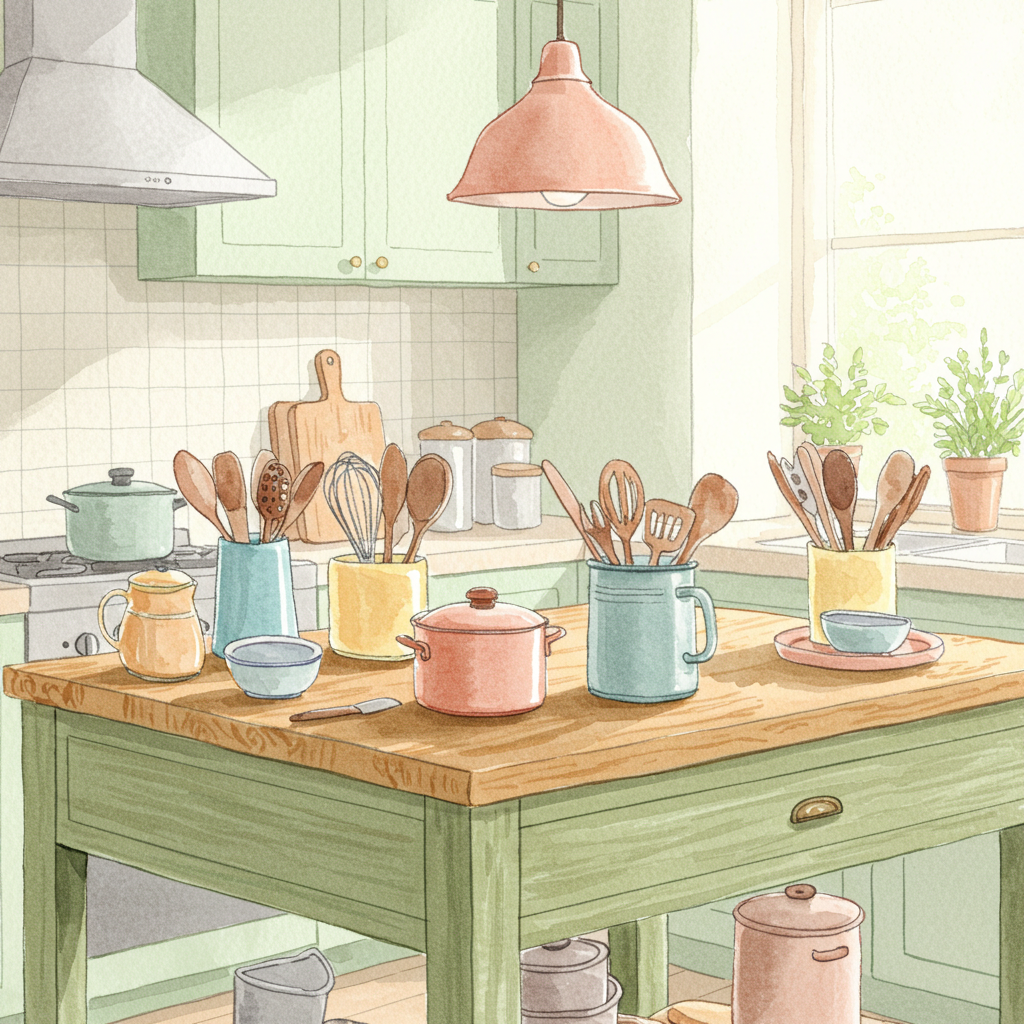

<font size='+1' color='brown'>🙋‍♂️<blockquote>
describe the image in detail
</blockquote></font>

<font size='+1' color='teal'>🤖<blockquote>
The image depicts a cozy and brightly lit kitchen scene with a focus on a wooden kitchen island. The overall style is reminiscent of a soft watercolor illustration, with gentle shading and a pastel color palette.

The central element is a sturdy wooden kitchen island with a light brown top and a sage green base. The island is cluttered with various kitchenware, suggesting a functional and lived-in space. 

On the island, there are several pots and pans of different sizes and colors. A light blue saucepan with a lid sits towards the left, followed by a small blue bowl. A terracotta pot with a lid rests next to it. Further to the right, a larger pink pot with a lid is visible, and a light blue pot also holds some cooking utensils.

A collection of wooden cooking utensils is neatly arranged in three cylindrical containers of different colors: a light blue, a yellow, and a light pink. These containers are filled with spoons, spatulas, whisks, and other tools. 

To the right of the utensils, there's a small light blue bowl with a pink saucer. Behind the island, a light green kitchen cabinet is visible, with two doors and a simple metal handle. A white tiled backsplash extends up the wall behind the cabinets. 

A large kitchen window is to the right, letting in ample natural light. Through the window, blurry green foliage is visible, suggesting an outdoor setting. Two small potted plants with green leaves sit on the windowsill. 

Hanging above the island is a pendant light fixture with a soft pink shade and a simple metallic chain. A stainless steel range hood is positioned above a stovetop on the left side of the kitchen. The floor is light-colored and slightly textured, adding to the overall feeling of a calm and inviting kitchen. 

The scene is full of gentle detail and a sense of warmth, inviting the viewer to imagine preparing a meal in this charming kitchen.
</blockquote></font>

In [ ]:
prompt = {
    "role": "user",
    "content": [
        {"type": "image", "image": f"{RESOURCE_URL_PREFIX}kitchen_painting.jpg"},
        {"type": "text", "text": "describe the image in detail"},
    ]
}

chat = ChatState(model, processor)
chat.send_message(prompt, max_tokens=512)

## Audio + Image : Tour Guide (image in + audio question)

This section demonstrates how to leverage Gemma 3n's multimodal input capability to assist as a Tour Guide. Take a picture of a famous landmark and ask any questions. Gemma 3n will act as your helpful tour guide.


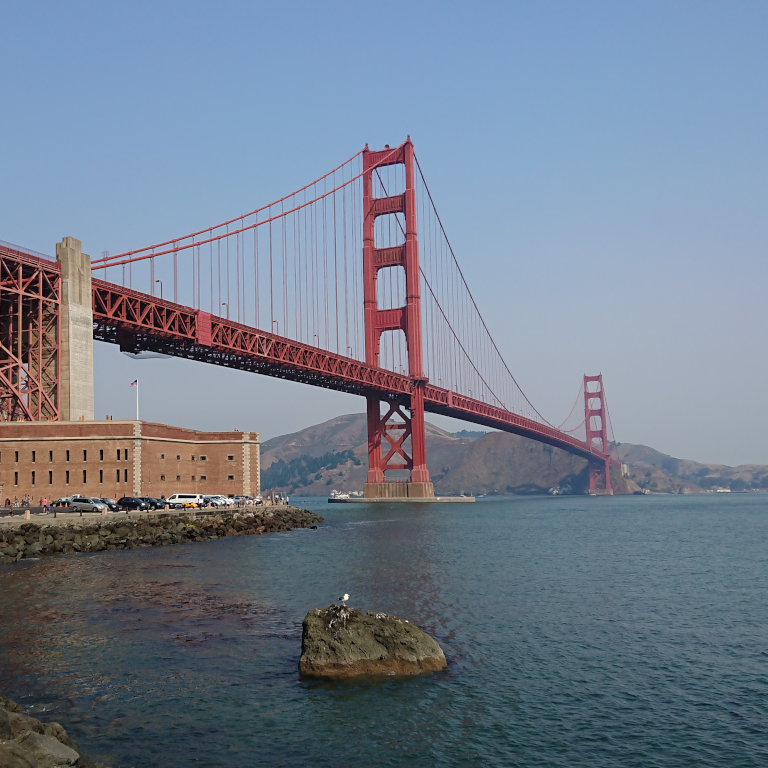

<font size='+1' color='teal'>🤖<blockquote>
This is the **Golden Gate Bridge** in **San Francisco, California**. 

It's an iconic suspension bridge spanning the Golden Gate strait, connecting San Francisco to Marin County. 

It's famous for its distinctive orange color, which helps to protect it from the corrosive effects of the salty air. 

</blockquote></font>

In [ ]:
prompt = {
  "role": "user",
  "content": [
    {"type": "image", "image": f"{RESOURCE_URL_PREFIX}GoldenGate.png"},
    {"type": "audio", "audio": f"{RESOURCE_URL_PREFIX}tour_en.wav"},
  ]
}

chat = ChatState(model, processor)
chat.send_message(prompt)

## Try this by yourself

In [ ]:
!pip install ipywebrtc

Press the circle button and start speaking. Click the circle button again when you are finshed. The widget will immediately begin to play back what it captured.

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

from ipywebrtc import AudioRecorder, CameraStream

camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

Convert webm file to wav format that PyTorch can understand.

In [ ]:
with open('/content/recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i /content/recording.webm /content/recording.wav -y

In [ ]:
prompt = {
  "role": "user",
  "content": [
    {"type": "image", "image": f"{RESOURCE_URL_PREFIX}GoldenGate.png"},
    {"type": "audio", "audio": "/content/recording.wav"},
  ]
}
chat = ChatState(model, processor)
chat.send_message(prompt)

## Next steps

Build and explore more with Gemma models:

* [Fine-tune Gemma for text tasks using Hugging Face Transformers](https://ai.google.dev/gemma/docs/core/huggingface_text_finetune_qlora)
* [Fine-tune Gemma for vision tasks using Hugging Face Transformers](https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora)
* [Perform distributed fine-tuning and inference on Gemma models](https://ai.google.dev/gemma/docs/core/distributed_tuning)
* [Use Gemma open models with Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/open-models/use-gemma)
* [Fine-tune Gemma using Keras and deploy to Vertex AI](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_gemma_kerasnlp_to_vertexai.ipynb)